In [2]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='webcam_capture.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [3]:
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/python/video.py
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/python/common.py
!wget https://raw.githubusercontent.com/opencv/opencv/master/samples/python/tst_scene_render.py

import sys
sys.path.append('/content')

import PIL

--2023-11-12 20:25:34--  https://raw.githubusercontent.com/opencv/opencv/master/samples/python/video.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7044 (6.9K) [text/plain]
Saving to: ‘video.py’

video.py            100%[===================>]   6.88K  --.-KB/s    in 0s      

2023-11-12 20:25:34 (73.3 MB/s) - ‘video.py’ saved [7044/7044]

--2023-11-12 20:25:34--  https://raw.githubusercontent.com/opencv/opencv/master/samples/python/common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6685 (6.5K) [text/plain]
Saving to: ‘c

In [6]:
from __future__ import print_function

import numpy as np
import cv2 as cv
import video

# Muestra una ventana que con el flujo óptico de las características detectadas para que con Drawflow se permita crear flujos de datos de manera fácil y rápida, donde se utiliza img.shape para proporcionar
# la dimension como la altura de la imagen, el ancho de la imagen y la cantidad de canales en la imagen auxiliar en diferentes índices con respecto al detector y seguimiento de movimiento.
def draw_flow(img, flow, step=16):
    h, w = img.shape[:2]
    y, x = np.mgrid[step/2:h:step, step/2:w:step].reshape(2,-1).astype(int)
    fx, fy = flow[y,x].T
    lines = np.vstack([x, y, x+fx, y+fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)
    vis = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    cv.polylines(vis, lines, 0, (0, 255, 0))
    for (x1, y1), (_x2, _y2) in lines:
        cv.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# Se utiliza la definición draw_hsv para el trazado del movimiento detectado con matrices de angulos en radiantes para el ajuste de valores en escalas de colores que se encontrara al identificar el entorno.
def draw_hsv(flow):
    h, w = flow.shape[:2]
    fx, fy = flow[:,:,0], flow[:,:,1]
    ang = np.arctan2(fy, fx) + np.pi
    v = np.sqrt(fx*fx+fy*fy)
    hsv = np.zeros((h, w, 3), np.uint8)
    hsv[...,0] = ang*(180/np.pi/2)
    hsv[...,1] = 255
    hsv[...,2] = np.minimum(v*4, 255)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    return bgr

# Se realia una deformación de imagen con respecto al flujo optico, por medio del mapeo de flujo, por lo que se esta interpolando los cuadros de video basada en deformación con la definición de warp_flow
# hacia adelante usando una red selectiva de movimiento con un valor de 0 y 1 en los rangos de especificado.
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv.remap(img, flow, None, cv.INTER_LINEAR)
    return res

# En la definición del punto de partida se encuentra la parte que muestra y despliega la camara para la aplicación de las capturas implementadas en el código, con el escalado en color para aplicar lo que son
# las funciones previas con la devolución de un a copia de la lectura de camara mostrando el flujo optico al seguir el movimiento.
def main():
    import sys
    try:
        fn = sys.argv[1]
    except IndexError:
        fn = 0

    #cam = cv.VideoCapture(0)
    #_ret, prev = cam.read()
    prev = cv.imread(take_photo())
    prevgray = cv.cvtColor(prev, cv.COLOR_BGR2GRAY)
    show_hsv = True
    show_glitch = True
    cur_glitch = prev.copy()

    for i in range(0,2):
        #_ret, img = cam.read()
        img = cv.imread(take_photo())
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Con la función de "cv.calcOpticalFlowFarneback" se realiza el cálculo del flujo óptico, por lo que el propósito general de un método de flujo óptico es encontrar el componente de
        # velocidad de cada píxel (si es denso) o de cada punto característico (si es disperso) entre dos imágenes (o cuadros de video, por lo general). La idea es que los píxeles del cuadro
        # N-1 se muevan a nuevas posiciones en el cuadro N, y la diferencia en la ubicación de estos píxeles es como un vector de velocidad. Eso significa que un píxel en la ubicación (x, y)
        # en el cuadro anterior estará en la ubicación (x+v_x, y+v_y) en el cuadro siguiente con respecto al algoritmo mostrado.
        flow = cv.calcOpticalFlowFarneback(prevgray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        prevgray = gray


        cv.imwrite('draw_flow.jpeg', draw_flow(gray, flow))
        PIL.Image.open('draw_flow.jpeg').show()
        #plt.imshow(draw_flow(gray, flow))
        if show_hsv:
            cv.imwrite('draw_hsv.jpeg', draw_hsv(flow))
            PIL.Image.open('draw_hsv.jpeg').show()
            #plt.imshow(draw_hsv(flow))
        if show_glitch:
            cur_glitch = warp_flow(cur_glitch, flow)
            cv.imwrite('cur_glitch.jpeg', cur_glitch)
            PIL.Image.open('cur_glitch.jpeg').show()
            #plt.imshow(cur_glitch)

        '''ch = cv.waitKey(5)
        if ch == 27:
            break
        if ch == ord('1'):
            show_hsv = not show_hsv
            print('HSV flow visualization is', ['off', 'on'][show_hsv])
        if ch == ord('2'):
            show_glitch = not show_glitch
            if show_glitch:
                cur_glitch = img.copy()
            print('glitch is', ['off', 'on'][show_glitch])'''

    print('Done')


if __name__ == '__main__':
    print(__doc__)
    main()
    #cv.destroyAllWindows()

Automatically created module for IPython interactive environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done


In [7]:
from __future__ import print_function

import numpy as np
import cv2 as cv

import video
from common import anorm2, draw_str

lk_params = dict( winSize  = (15, 15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

feature_params = dict( maxCorners = 500,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

class App:
    def __init__(self, video_src):
        self.track_len = 10
        self.detect_interval = 5
        self.tracks = []
        #self.cam = video.create_capture(video_src)
        self.frame_idx = 0

    def run(self):
        for i in range(0,2):
            #_ret, frame = self.cam.read()
            frame = cv.imread(take_photo())
            frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
            vis = frame.copy()

            if len(self.tracks) > 0:
                img0, img1 = self.prev_gray, frame_gray
                p0 = np.float32([tr[-1] for tr in self.tracks]).reshape(-1, 1, 2)

                # En la función de "cv.calcOpticalFlowPyrLK" se obtienen en primer lugar los puntos antiguos, enseguida los nuevos puntos de puntos antiguos, luego los puntos antiguos inferiores a partir de
                # puntos nuevos y finalmente se comparan entre puntos antiguos y puntos antiguos inferidos, por lo que toma el vector de puntos de la imagen anterior como entrada y devuelve los puntos
                # apropiados en la siguiente imagen, con la ubicación del píxel en la ubicación (x, y) con la ubicación (x+v_x, y+v_y) en el cuadro proximo obteniendo el cálculo óptico.
                p1, _st, _err = cv.calcOpticalFlowPyrLK(img0, img1, p0, None, **lk_params)
                p0r, _st, _err = cv.calcOpticalFlowPyrLK(img1, img0, p1, None, **lk_params)
                d = abs(p0-p0r).reshape(-1, 2).max(-1)
                good = d < 1
                new_tracks = []
                for tr, (x, y), good_flag in zip(self.tracks, p1.reshape(-1, 2), good):
                    if not good_flag:
                        continue
                    tr.append((x, y))
                    if len(tr) > self.track_len:
                        del tr[0]
                    new_tracks.append(tr)
                    cv.circle(vis, (int(x), int(y)), 2, (0, 255, 0), -1)
                self.tracks = new_tracks
                cv.polylines(vis, [np.int32(tr) for tr in self.tracks], False, (0, 255, 0))
                draw_str(vis, (20, 20), 'track count: %d' % len(self.tracks))

            if self.frame_idx % self.detect_interval == 0:
                mask = np.zeros_like(frame_gray)
                mask[:] = 255
                for x, y in [np.int32(tr[-1]) for tr in self.tracks]:
                    cv.circle(mask, (x, y), 5, 0, -1)

                # La función "cv.goodFeaturesToTrack()" tiene como principal función la evaluación de saber si un punto es una esquina o no, Primero, esta función calcula el puntaje de calidad de la esquina
                # en cada píxel usando Shi-Tomasi o Harris Corner, por consiguiente realiza una supresión no máxima y creando una imagen de máscara con fines de dibujo para la función de movimiento.
                p = cv.goodFeaturesToTrack(frame_gray, mask = mask, **feature_params)
                if p is not None:
                    for x, y in np.float32(p).reshape(-1, 2):
                        self.tracks.append([(x, y)])


            self.frame_idx += 1
            self.prev_gray = frame_gray
            cv.imwrite('vis.jpeg', vis)
            PIL.Image.open('vis.jpeg').show()

            '''ch = cv.waitKey(1)
            if ch == 27:
                break'''

def main():
    import sys
    try:
        video_src = sys.argv[1]
    except:
        video_src = 0

    App(video_src).run()
    print('Done')


if __name__ == '__main__':
    print(__doc__)
    main()
    #cv.destroyAllWindows()

Automatically created module for IPython interactive environment


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Done


# **Parte 2**

In [8]:
# Se instala opencv-python para usar las librerias correspondientes y necesarias.
!pip install opencv-python

In [9]:
# Se importan las librerías de para capturar, detectar y procesar los rostros de las personas en la imagen con la que se trabaja en la Fase II.
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

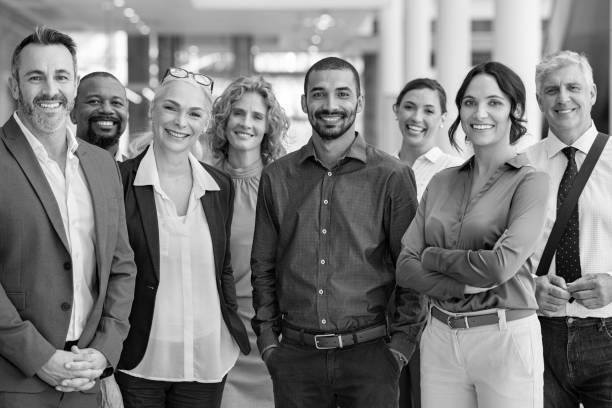

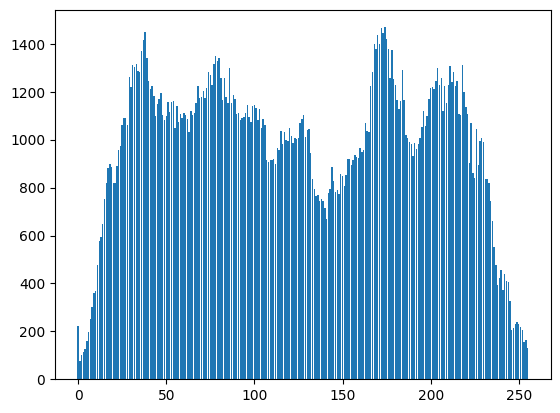

In [12]:
# Se carga la imagen con la que se desarrollara la segunda fase en escalas de grises procesando la imagen y realizando la comparación con su respectiva ecualización de histograma.
img = cv2.imread('istockphoto-1346125184-612x612.jpg', cv2.IMREAD_GRAYSCALE)
width, height = img.shape

cv2_imshow (img)
x = np.linspace(0,255, num=256, dtype = np.uint8)
y = np.zeros(256)

for w in range (width):
	for h in range (height):
		v=img[w,h]
		y[v] = y[v]+1;
plt.bar(x,y)
plt.show()

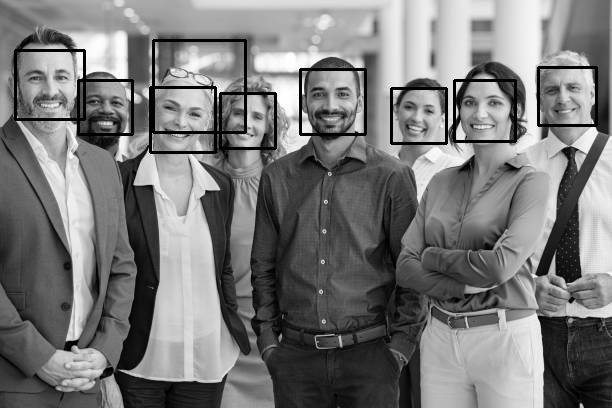

In [15]:
# En esta parte del código se implementa el detector de rostros, empezando con el guardado en la función faceClassif del despliegue del xml de un clasificador de rostros previamente entrenado con Haar Cascade de OpenCV por parte de GitHub,
# mismo donde se llama a la función "detectMultiScale" introduciendo el factor de escalado de la imagen a un valor de escala original (1.1), ajustando los parámetros de minNeighbors con la frecuencia de reconocimiento de posible rostro para
# ajustar el promedio de rostros vecinos o cercanos, el mínimo y el máximo escalado de tamaño detectado del recuadro identificador de rostros en la imagen  con "minSize" y "maxSize" respectivamente, ajustando las dimensiones de los recuadros.
import cv2
import numpy as np

faceClassif = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')

faces = faceClassif.detectMultiScale(img,
	scaleFactor=1.1,
	minNeighbors=5,
	minSize=(30,30),
	maxSize=(200,200))

for (x,y,w,h) in faces:
	cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()

Face detected in the image: 8


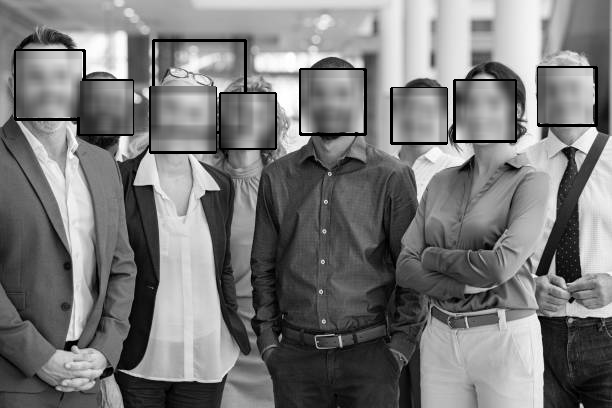

In [16]:
# Finalmente se usa la variable reservada con haar cascade para la detección de rostros de la líne anterior, utilizando el factor de escala original y el tamaño ajustado para los rostros de la imagen, implementando el código de filtro gaussiano,
# con un bucle sobre todas las caras detectadas en la imagen, se aplica el filtro gaussiano de desenfoque o "blur"  al rectángulo de la cara, agregando una cara borrosa en la imagen original para obtener y mostarel resultado de la imagen final.
faces = faceClassif.detectMultiScale(img, 1.1, 5)
print("Face detected in the image:", len(faces))


for (x, y, w, h) in faces:
   roi = img[y:y+h, x:x+w]


   roi = cv2.GaussianBlur(roi, (15, 15), 30)


   img[y:y+roi.shape[0], x:x+roi.shape[1]] = roi


cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()